# Resting EEG Data

This notebook analyzes a dataset of EEG data collected from healthy young adults.

## Dataset Details

This dataset is a dataset of extra-cranial EEG data recorded in the Voytek Lab. 

Analyzed data is taken from eyes-closed resting state data collected prior to a visual-detection psychophysics task.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from fooof import FOOOF, FOOOFGroup
from fooof.utils import trim_spectrum
from fooof.objs import combine_fooofs

from neurodsp.utils import create_times
from neurodsp.spectral import compute_spectrum
from neurodsp.plts import plot_time_series, plot_power_spectra

/var/folders/59/8y2d5r257c77vzymnqs47x080000gn/T/ipykernel_50483/1192339103.py:4: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF, FOOOFGroup


In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.io import APMDB, get_files, load_pickle
from apm.io.data import load_eeg_demo_group_data, load_eeg_demo_info
from apm.analysis import (compute_avgs, unpack_corrs, compute_all_corrs,
                          compute_corrs_to_feature, compute_diffs_to_feature)
from apm.plts import plot_dots, plot_corr_matrix
from apm.plts.results import plot_topo
from apm.plts.multi import plot_results_all, plot_topo_row
from apm.plts.utils import make_axes
from apm.plts.settings import EXT, LABELS
from apm.utils import format_corr

In [3]:
# Import dataset settings from script
sys.path.append(str(Path('..').resolve() / 'scripts'))
from scripts.analyze_eeg1 import DATA_FOLDER, FS, N_SECONDS, FIT_RANGE

In [4]:
import seaborn as sns
sns.set_context('talk')

## Set Up Paths

In [5]:
# Define load path
db = APMDB()
LOADPATH = db.data_path / 'eeg1'

In [6]:
# Check the set of results files available for this dataset
get_files(LOADPATH)

['eeg1_results.p',
 'eeg1_results_peaks.p',
 'eeg1_spatial_alpha_corrs_diffs.p',
 'eeg1_spatial_corrs.p',
 'eeg1_spatial_corrs_alpha.p',
 'eeg1_spatial_corrs_exp.p',
 'specparam']

## Settings

In [7]:
# Define times vector for data
times = create_times(N_SECONDS + 1 / FS, FS)

In [8]:
# Add plot kwargs
dot_kwargs = {
    'alpha' : 0.75,
}

In [9]:
# Settings for saving figures
SAVE_FIG = True
FIGPATH = db.figs_path / '51_eeg_data'

## Load Data


In [10]:
# Load group data
group_data = load_eeg_demo_group_data(DATA_FOLDER)

In [11]:
# Check data size
n_subjs, n_chs, n_times = group_data.shape
print('Number of subjects: {}'.format(n_subjs))

Number of subjects: 29


In [12]:
# Load MNE info object for the current dataset
info = load_eeg_demo_info(DATA_FOLDER)

## Data Checks

In [13]:
# Set example subject index
subj_ind = 13

In [14]:
# Set example channel index
chi = 29

In [15]:
info.ch_names

['Fp1',
 'Fp2',
 'F7',
 'F3',
 'Fz',
 'F4',
 'F8',
 'FC5',
 'FC1',
 'FC2',
 'FC6',
 'T7',
 'C3',
 'Cz',
 'C4',
 'T8',
 'TP9',
 'CP5',
 'CP1',
 'CP2',
 'CP6',
 'TP10',
 'P7',
 'P3',
 'Pz',
 'P4',
 'P8',
 'PO9',
 'O1',
 'Oz',
 'O2',
 'PO10',
 'AF7',
 'AF3',
 'AF4',
 'AF8',
 'F5',
 'F1',
 'F2',
 'F6',
 'FT9',
 'FT7',
 'FC3',
 'FC4',
 'FT8',
 'FT10',
 'C5',
 'C1',
 'C2',
 'C6',
 'TP7',
 'CP3',
 'CPz',
 'CP4',
 'TP8',
 'P5',
 'P1',
 'P2',
 'P6',
 'PO7',
 'PO3',
 'POz',
 'PO4',
 'PO8']

In [16]:
# Check example channel label
info.ch_names[chi]

'Oz'

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


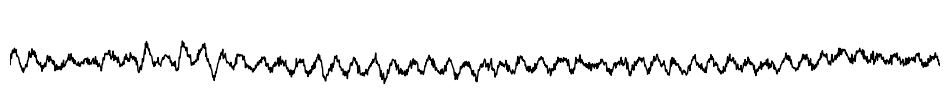

In [17]:
# Plot a segment of time series data
plot_time_series(times, group_data[subj_ind, chi, :], lw=1., xlim=[5, 10], figsize=(12, 1))
plt.gca().axis('off');
if SAVE_FIG: plt.savefig(FIGPATH / ('eeg_timeseries' + EXT))

In [18]:
# Compute a power spectrum of an example
freqs, powers = compute_spectrum(group_data[subj_ind, chi, :], FS, nperseg=2*FS, noverlap=FS)

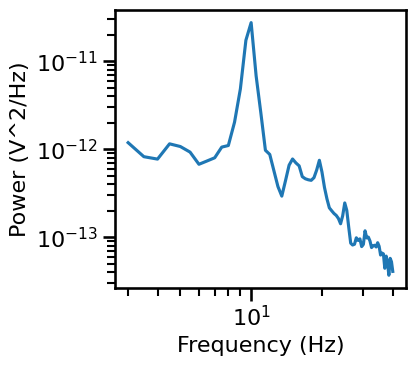

In [19]:
# Plot the power spectrum of the example data segment
plot_power_spectra(*trim_spectrum(freqs, powers, [3, 40]), figsize=(4.5, 4), 
                   save_fig=SAVE_FIG, file_name='rest_eeg_psd' + EXT, file_path=FIGPATH)

### Check Spectral Fits

In [20]:
# Load specparam measures
all_fgs = []
temp = FOOOFGroup()
for fres in get_files(LOADPATH / 'specparam'):
    temp.load(fres, LOADPATH / 'specparam')
    all_fgs.append(temp.copy())
fg = combine_fooofs(all_fgs)

                                                                                                  
                                       FOOOF - GROUP RESULTS                                      
                                                                                                  
                            Number of power spectra in the Group: 1856                            
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                              Power spectra were fit without a knee.                              
                                                                                                  
          

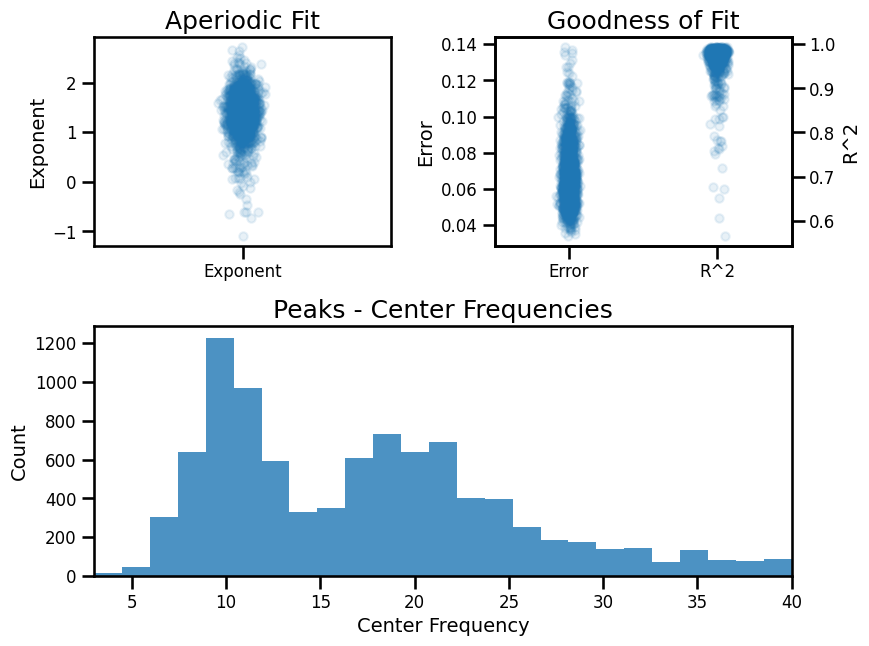

In [21]:
# Check overall group results
fg.print_results()
fg.plot()

## Load Results

In [22]:
# Load precomputed aperiodic measure results
group_results = load_pickle('eeg1_results', LOADPATH)

In [23]:
# Check size of computed results [n_subjs, n_chs]
group_results['dfa'].shape

(29, 64)

In [24]:
# Load precomputed peak results
group_results_peaks = load_pickle('eeg1_results_peaks', LOADPATH)

#### Check Measures & Labels

In [25]:
# Check list of computed measures
print(list(group_results.keys()))

['autocorr_decay_time', 'dfa', 'higuchi_fd', 'hjorth_complexity', 'lempelziv', 'sample_entropy', 'perm_entropy', 'irasa', 'specparam']


In [26]:
# Collect list of exponent & timeseries measure labels
exp_measures = ['specparam', 'irasa']
ts_measures = list(group_results.keys())
[ts_measures.remove(meas) for meas in exp_measures];

In [27]:
# Collect labels for time series measures
ts_labels = [LABELS[meas] for meas in ts_measures]

#### Extract Measures for Example Channel

In [28]:
# Sub-select results to channel of interest
results = {key : val[:, chi] for key, val in group_results.items()}
results_peaks = {key : val[:, chi] for key, val in group_results_peaks.items()}

In [29]:
# Update missing value for AC value at Cz
results['autocorr_decay_time'][9] = np.mean([group_results['autocorr_decay_time'][9, 28], 
                                             group_results['autocorr_decay_time'][9, 30]])

In [30]:
# Compute correlations for selected channel
all_corrs = compute_all_corrs(results)

### Compare Exponent Measures

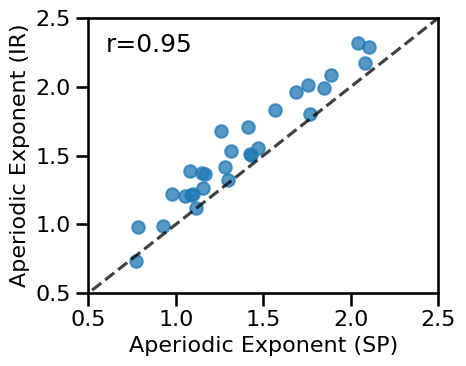

In [31]:
# Plot the comparison of specparam and IRASA exponent estimations
plot_dots(results['specparam'], results['irasa'], **dot_kwargs, figsize=(5, 4),
          xlim=[0.5, 2.5], ylim=[0.5, 2.5], tposition='tl', expected=[0, 3],
          xlabel='Aperiodic Exponent (SP)', ylabel='Aperiodic Exponent (IR)',
          save_fig=SAVE_FIG, file_name='eeg_exp_exp_comp' + EXT, file_path=FIGPATH)

In [32]:
# Check correlation between specparam and irasa exponent estimates
print('  SP-EXP & IR-EXP:  ', format_corr(*all_corrs['specparam']['irasa']))

  SP-EXP & IR-EXP:   r=+0.946  CI[+0.854, +0.978],  p=0.000


### Compare Exponent to Time Series Measures

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


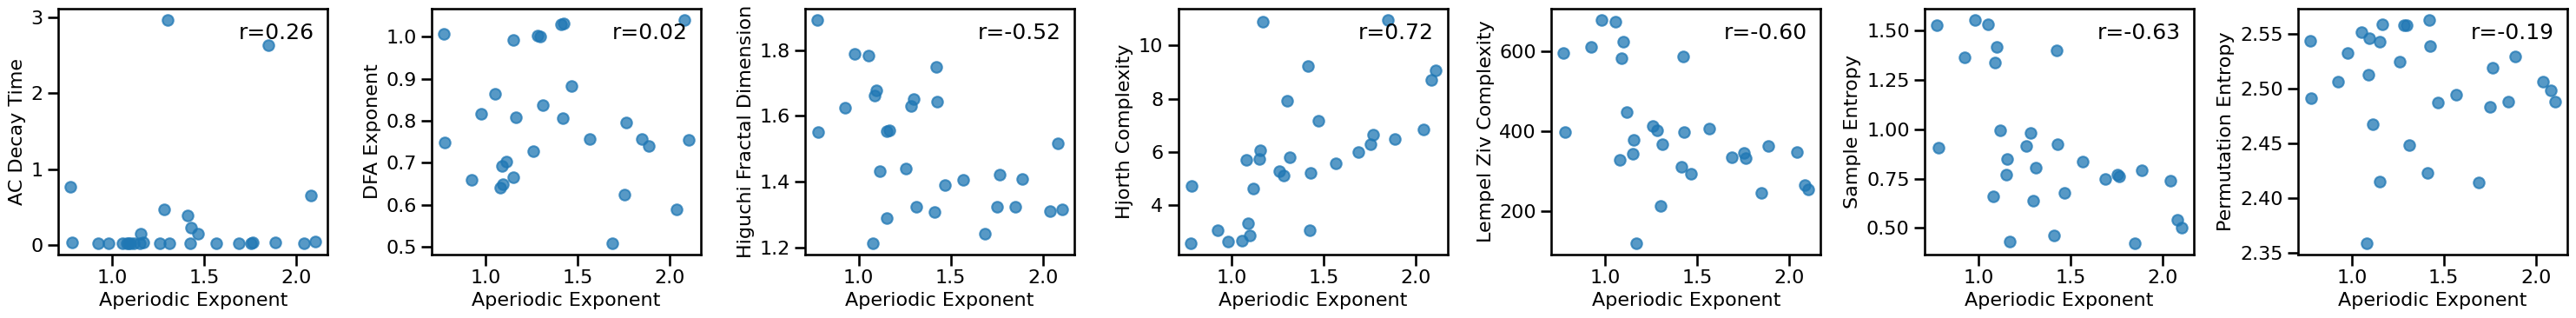

In [33]:
# Plot comparisons between exponent and time series measures
axes = make_axes(1, len(ts_measures), figsize=(30, 4), wspace=0.05)
for ind, meas in enumerate(ts_measures):
    plot_dots(results['specparam'], results[meas], **dot_kwargs,
              xlabel='Aperiodic Exponent', ylabel=LABELS[meas], ax=axes[ind])
if SAVE_FIG: plt.savefig(FIGPATH / ('eeg1_exp_ts_scatters' + EXT))

In [34]:
# Check the correlations between time series and exponent measures
for meas in ts_measures:
    print(meas)
    print('    SP-EXP:  ', format_corr(*all_corrs['specparam'][meas]))
    print('    IR-EXP:  ', format_corr(*all_corrs['irasa'][meas]))

autocorr_decay_time
    SP-EXP:   r=+0.261  CI[-0.121, +0.608],  p=0.172
    IR-EXP:   r=+0.130  CI[-0.257, +0.500],  p=0.501
dfa
    SP-EXP:   r=+0.017  CI[-0.383, +0.428],  p=0.931
    IR-EXP:   r=-0.098  CI[-0.502, +0.318],  p=0.613
higuchi_fd
    SP-EXP:   r=-0.517  CI[-0.772, -0.159],  p=0.004
    IR-EXP:   r=-0.638  CI[-0.805, -0.370],  p=0.000
hjorth_complexity
    SP-EXP:   r=+0.723  CI[+0.467, +0.877],  p=0.000
    IR-EXP:   r=+0.693  CI[+0.419, +0.846],  p=0.000
lempelziv
    SP-EXP:   r=-0.605  CI[-0.804, -0.285],  p=0.001
    IR-EXP:   r=-0.572  CI[-0.763, -0.231],  p=0.001
sample_entropy
    SP-EXP:   r=-0.628  CI[-0.825, -0.335],  p=0.000
    IR-EXP:   r=-0.636  CI[-0.806, -0.349],  p=0.000
perm_entropy
    SP-EXP:   r=-0.190  CI[-0.476, +0.144],  p=0.323
    IR-EXP:   r=-0.309  CI[-0.555, +0.004],  p=0.102


### Compare Time Series Measures to Each Other

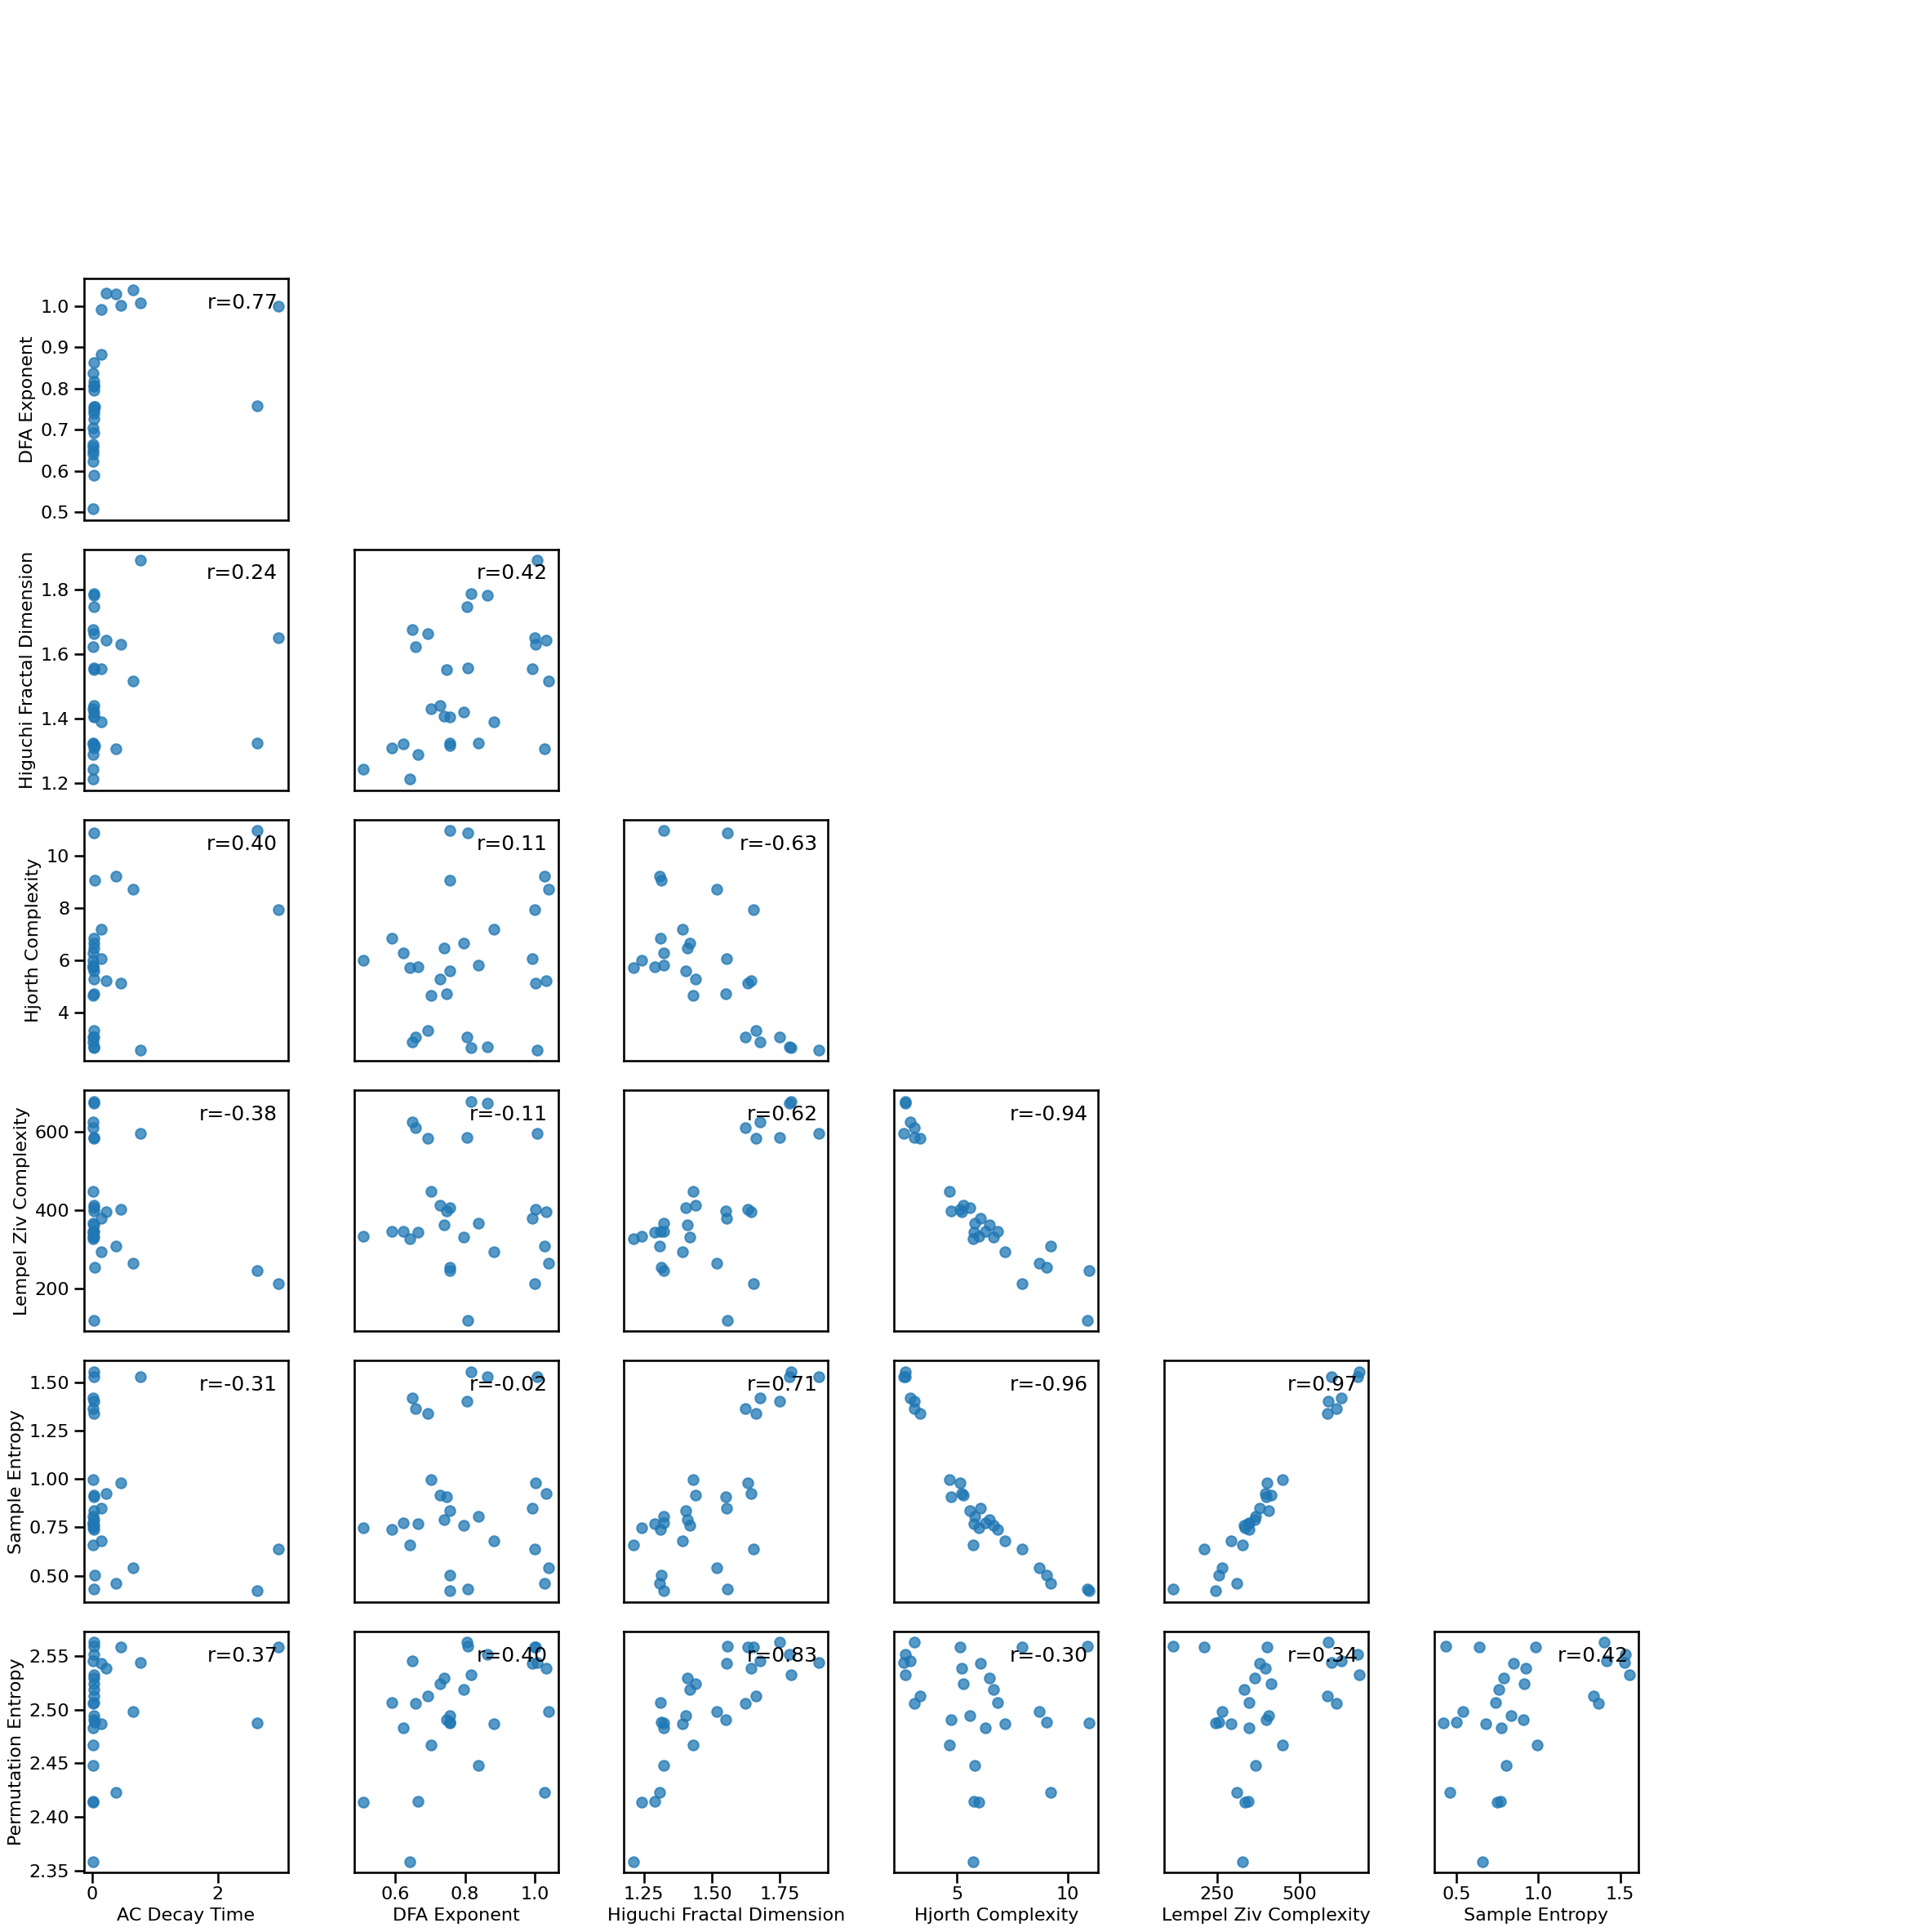

In [35]:
# Plot multi-panel plot comparing all time series measures to each other
plot_results_all(results, ts_measures)

#### Correlations

In [36]:
# Subselect time domain measures
all_corrs_ts = {ke : va for ke, va in all_corrs.items() if ke not in exp_measures}

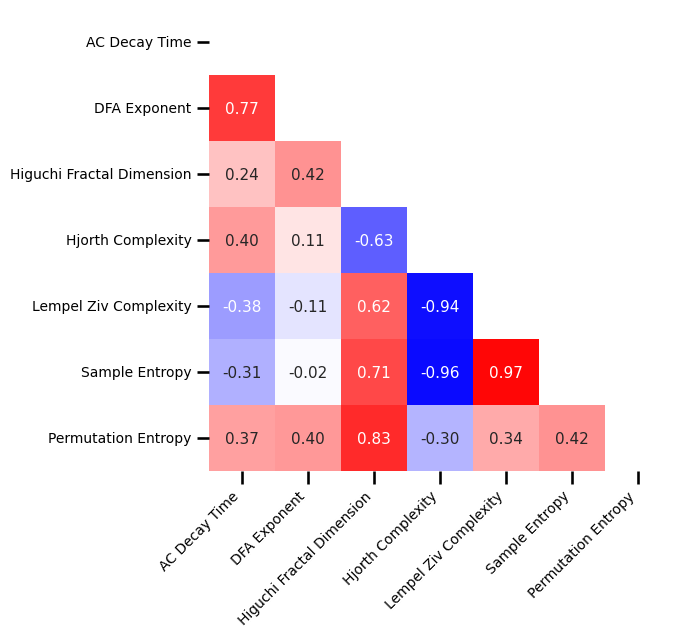

In [37]:
# Plot the correlations matrix across all time series measures
plot_corr_matrix(unpack_corrs(all_corrs_ts), cbar=False, figsize=(6, 6),
                 xticklabels=ts_labels, yticklabels=ts_labels,
                 save_fig=SAVE_FIG, file_name='subj_corrs_ts' + EXT, file_path=FIGPATH)

In [38]:
# Extract the correlations between specparam and time domain measures
exp_corrs_subjs = np.atleast_2d([all_corrs['specparam'][label][0] for label in ts_measures]).T

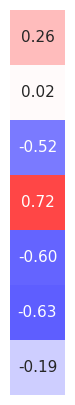

In [39]:
# Plot correlations between exponent and time domain measures
plot_corr_matrix(exp_corrs_subjs, cbar=False, figsize=(1.5, 5),
                 save_fig=SAVE_FIG, file_name='subj_corrs_exp' + EXT, file_path=FIGPATH)

### Compare to Alpha Power

In [40]:
# Compute correlations between measures at selected electrode and alpha
alpha_corrs = compute_corrs_to_feature(results, results_peaks['alpha_power'])

In [41]:
# # Compute differences between correlations to alpha
# alpha_corr_diffs = compute_diffs_to_feature(results, results_peaks['alpha_power'])

In [42]:
# Check the correlations between alpha power and aperiodic measures
print('Correlations with alpha:')
for label in alpha_corrs.keys():
    print('     {:20s}:  '.format(label), format_corr(*alpha_corrs[label]))

Correlations with alpha:
     autocorr_decay_time :   r=-0.464  CI[-0.714, -0.122],  p=0.011
     dfa                 :   r=-0.636  CI[-0.810, -0.365],  p=0.000
     higuchi_fd          :   r=-0.635  CI[-0.837, -0.324],  p=0.000
     hjorth_complexity   :   r=+0.317  CI[-0.102, +0.617],  p=0.094
     lempelziv           :   r=-0.324  CI[-0.610, +0.056],  p=0.086
     sample_entropy      :   r=-0.388  CI[-0.668, +0.006],  p=0.038
     perm_entropy        :   r=-0.595  CI[-0.807, -0.297],  p=0.001
     irasa               :   r=+0.309  CI[-0.047, +0.618],  p=0.103
     specparam           :   r=+0.287  CI[-0.081, +0.598],  p=0.132


In [43]:
# Organize correlations between alpha and time domain measures
alpha_corrs_ts = np.atleast_2d([alpha_corrs[label][0] for label in ts_measures]).T

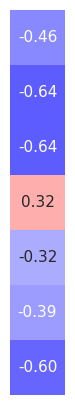

In [44]:
# Plot correlations between alpha and time domain measures
plot_corr_matrix(alpha_corrs_ts, cbar=False, figsize=(1.5, 5),
                 save_fig=SAVE_FIG, file_name='subj_corrs_alpha' + EXT, file_path=FIGPATH)

## Spatial Analyses

#### Compute Measures Across Channels

In [45]:
# Compute the average across the group
group_avg = compute_avgs(group_results, np.nanmean)

#### Exponent Topograghies

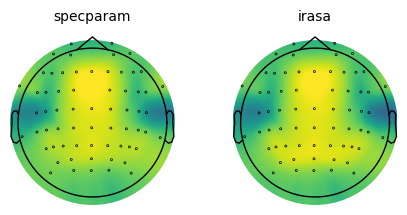

In [46]:
# Plot the group average topographies for the exponent measures
plot_topo_row(group_avg, exp_measures, info,
              save_fig=SAVE_FIG, file_name='exp_topos' + EXT, file_path=FIGPATH)

#### Time Series Measure Topographies

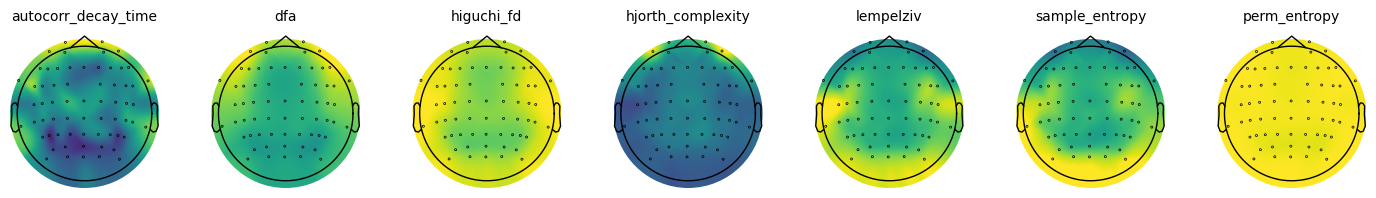

In [47]:
# Plot the group average topographies for the time domain measures
plot_topo_row(group_avg, ts_measures, info,
              save_fig=SAVE_FIG, file_name='eeg1_topo_row' + EXT, file_path=FIGPATH)

### Spatial Correlations

In [48]:
# Load precomputed group correlation results
group_corrs = load_pickle('eeg1_spatial_corrs', LOADPATH)

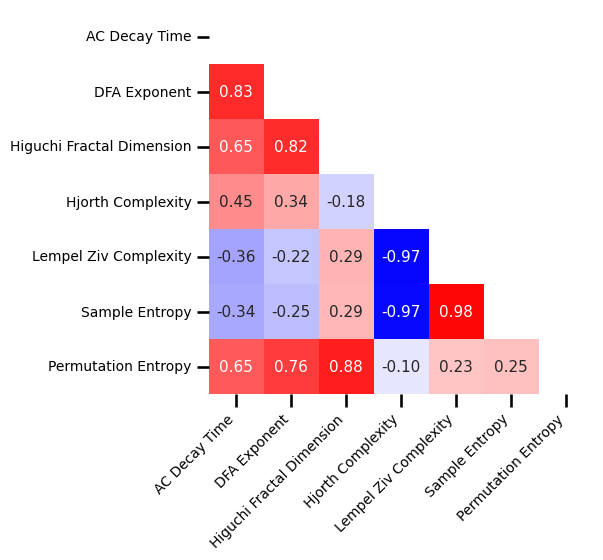

In [49]:
# Plot the correlation matrix of spatial topographies
plot_corr_matrix(unpack_corrs(group_corrs), cbar=False, figsize=(5, 5),
                 xticklabels=ts_labels, yticklabels=ts_labels,
                 save_fig=SAVE_FIG, file_name='space_corrs_ts' + EXT, file_path=FIGPATH)

In [50]:
# Load precomputed group exponent correlation results
group_exp_corrs = load_pickle('eeg1_spatial_corrs_exp', LOADPATH)

In [51]:
# Organize the correlations between the exponent and time domain measures
exp_corr_mat = np.atleast_2d([group_exp_corrs[label][0] for label in group_exp_corrs]).T

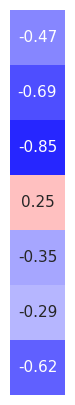

In [52]:
# Plot the correlations between exponent and time domain measures
plot_corr_matrix(exp_corr_mat, cbar=False, figsize=(1.5, 5),
                 save_fig=SAVE_FIG, file_name='space_corrs_exp' + EXT, file_path=FIGPATH)

## Alpha Power Topography

In [53]:
# Compute the average alpha topography across the group
group_avg_peaks = compute_avgs(group_results_peaks, np.nanmean)

In [54]:
# Check range of alpha power values
amin, amax = np.min(group_avg_peaks['alpha_power']), np.max(group_avg_peaks['alpha_power'])
amin, amax

(-11.505512552707579, -10.321239762330212)

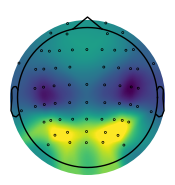

In [55]:
# Plot the average alpha topography across the group
plot_topo(group_avg_peaks['alpha_power'], info, vlim=(-11.5, -10.5),
          save_fig=SAVE_FIG, file_name='alpha_topo' + EXT, file_path=FIGPATH)

In [56]:
# Load precomputed correlations between aperiodic measures and alpha power
group_alpha_corrs = load_pickle('eeg1_spatial_corrs_alpha', LOADPATH)

In [57]:
# Organize the alpha correlations
alpha_corr_mat = np.atleast_2d([group_alpha_corrs[label][0] for label in group_alpha_corrs]).T

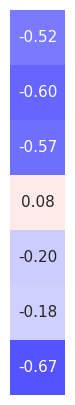

In [58]:
# Plot the correlations between alpha activity and time domain measures
plot_corr_matrix(alpha_corr_mat, cbar=False, figsize=(1.5, 5),
                 save_fig=SAVE_FIG, file_name='space_corrs_alpha' + EXT, file_path=FIGPATH)

## Conclusions

Conclusions of this empirical data analysis thus far:
- in this EEG data, the specparam & IRASA exponent estimates are highly comparable
- in this empirical data, aperiodic exponent is moderately correlated with the time domain methods

Note that this dataset is analyzed as a small / pilot, such that these interim conclusions are not considered decisive, and are best considered as initial results to be further explored and replicated in subsequent larger datasets.